# This notebook includes a simple demo for flood risk assessment

## It uses flood hazard water depth scenario RP100 and population map for 2018

In [1]:
# Added to requirements.txt, but need to specify version? Then remove here
!pip -q install geopandas
!apt -q install libspatialindex-dev
!pip -q install osmnx
!pip -q install rasterio
!pip -q install rasterstats
!pip -q install geojson

Reading package lists...
Building dependency tree...
Reading state information...
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [5]:
# !git clone https://github.com/gfdrr/rdl-pytools.git
!cd rdl-pytools && git pull origin main

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 3), reused 7 (delta 2), pack-reused 0
Unpacking objects: 100% (10/10), done.
From https://github.com/gfdrr/rdl-pytools
 * branch            main       -> FETCH_HEAD
   11fecfc..18d556d  main       -> origin/main
Updating 11fecfc..18d556d
Fast-forward
 data/ssudan/hzd-ss-fl-rp100.cpg |   1 +
 data/ssudan/hzd-ss-fl-rp100.dbf | Bin 0 -> 715426 bytes
 data/ssudan/hzd-ss-fl-rp100.prj |   1 +
 data/ssudan/hzd-ss-fl-rp100.shp | Bin 0 -> 14079088 bytes
 data/ssudan/hzd-ss-fl-rp100.shx | Bin 0 -> 572388 bytes
 ss-fl-pop.ipynb                 | 783 +++++++++++++++++++++++++++++++++++++++-
 6 files changed, 784 insertions(+), 1 deletion(-)
 create mode 100644 data/ssudan/hzd-ss-fl-rp100.cpg
 create mode 100644 data/ssudan/hzd-ss-fl-rp100.dbf
 create mode 100644 data/ssudan/hzd-ss-fl-rp100.prj
 create mode 100644 data/ssudan/hzd-ss-fl-rp100.shp

### Import required libraries

In [7]:
# Required libraries
import tempfile

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.plot import show

from rasterstats import zonal_stats, utils

import gdal, gdalconst
from osgeo import ogr, osr
from shapely import wkb
from matplotlib import pyplot
from shapely.geometry import shape



In [67]:
# Helper functions to perform analysis

def collect_stats(src_file, shp, target_data, stats, colname):
  """
  Parameters
  ----------
  src_file : source raster file to extract metadata from
  shp : shapefile used to select spatial area
  target_data : np.ndarray, of data
  stats : str or List[str], collection of statistics to calculate
  colname : str, target column in `shp`
  """
  # Write flood population raster to temporary file
  temp = tempfile.NamedTemporaryFile(suffix=".tiff")

  # Need source data information so that outputted data profile matches
  with rasterio.open(src_file) as src:
    with rasterio.Env():
      profile = src.profile

      # band count = 1, dtype to int32, and use LZW compression
      profile.update(
          dtype=rasterio.int32,
          count=1,
          compress='lzw')

      # Write out to the temporary file
      with rasterio.open(temp.name, 'w', **profile) as dst:
        dst.write(target_data.astype(rasterio.int32), 1)

    # Perform zonal statistics on temporary file using the ADM2 shapefile
    shp_data = gpd.read_file(shp)
    result = {}
    for geom in shp_data.itertuples():
      result[getattr(geom, colname)] = zonal_stats(geom.geometry,
                                                   temp.name,
                                                   stats=stats)
    
    return result


def convert_stats_to_df(data, col_name, stat_name):
  """
  data : result from `collect_stats()`
  col_name : str, desired name of column in DataFrame
  stat_name : str, name of statistic used in `collect_stats()`
  """
  tmp = {k: v[0][stat_name] for (k, v) in data.items()}
  res = pd.DataFrame.from_dict(tmp, orient='index', columns=[col_name])
  return res

### Load input data: flood hazard (RP100) and population (Landscan 2018)

All data already share the same crs (epsg 4326)

In [132]:
base_loc = "rdl-pytools/data/ssudan/"

#pop represents population data
with rasterio.open(base_loc+'exp-ss-pop-landscan18.tif') as fp:
  pop_data = fp.read(1)

  # Get cell size for count of affected area later on
  gt = fp.transform
  pixelSizeX = gt[0]
  pixelSizeY =-gt[4]


scale_factor = 0.1
with rasterio.open(base_loc+'hzd-ss-fl-rp100.tif') as dataset:
  # resample data to population data resolution
  data = dataset.read(
      out_shape=(
          dataset.count,
          int(fp.height),
          int(fp.width)
      ),
      resampling=Resampling.bilinear
  )

  

  # scale image transform
  transform = dataset.transform * dataset.transform.scale(
      (dataset.width / pop_data.shape[-1]),
      (dataset.height / pop_data.shape[-2])
  )

flood_data = data[0, :, :]


In [133]:
pixelSizeX, pixelSizeY

(0.008333333333333333, 0.008333333333333333)

In [16]:
flood_extent = gpd.read_file(base_loc+"hzd-ss-fl-rp100.shp")

In [111]:
flood_extent.columns

Index(['OBJECTID', 'geometry'], dtype='object')

In [19]:
# Flood resolution and population data resolution should match
flood_data.shape == pop_data.shape

True

In [120]:
flood_data.shape

(1050, 1416)

In [20]:
#adm represents administrative units
adm0 = gpd.read_file(base_loc+'SS_ADM0.shp')
adm1 = gpd.read_file(base_loc+'SS_ADM1.shp')
adm2 = gpd.read_file(base_loc+'SS_ADM2.shp')

## 1. Flooded area

In [113]:
# with rasterio.open(base_loc+'hzd-ss-fl-rp100.tif') as dataset:
#   flood_area = dataset.read(1)

In [118]:
adm1_flooded_areas = collect_stats(base_loc+'hzd-ss-fl-rp100.tif', base_loc+'SS_ADM1.shp', flood_data, ["count"], 'ADM1_PCODE')

In [121]:
flooded_area_df = convert_stats_to_df(adm1_flooded_areas, 'flooded_area', 'count')

# Convert count of cells into expected spatial resolution in degrees
flooded_area_df['flooded_area'] *= pixelSizeX*pixelSizeY

6.944444444444444e-05

<AxesSubplot:>

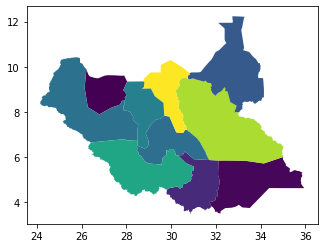

In [123]:
flooded_area_deg = adm1.join(flooded_area_df, on='ADM1_PCODE')

flooded_area_deg.plot(column='flooded_area')

### Export output

In [27]:
# area.to_csv(os.path.join(out_folder, "area_flooded.csv"))

In [28]:
# out_folder = os.path.join(data_dir, "output")
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

## 2. Flooded population

### Create flood hazard extent mask using a threshold of 15 cm

In [21]:
# Get flooded areas
flood_mask = np.where(flood_data > 0.15, 1, 0)

In [24]:
# Flood mask should match population data resolution
flood_mask.shape == pop_data.shape

True

### Estimate population within hazard extent and plot as map

In [42]:
pop_fd = flood_mask * pop_data

<AxesSubplot:>

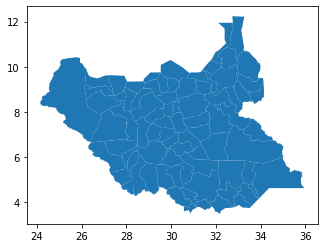

In [27]:
adm2.plot()

Summary for ADM2 level - zonal statistics

In [68]:
adm1_stats = collect_stats(base_loc+'hzd-ss-fl-rp100.tif', base_loc+'SS_ADM1.shp', pop_fd, stats="sum", colname='ADM1_PCODE')

In [69]:
adm2_stats = collect_stats(base_loc+'hzd-ss-fl-rp100.tif', base_loc+'SS_ADM2.shp', pop_fd, stats="sum", colname='ADM2_PCODE')

In [93]:
res_df = convert_stats_to_df(adm1_stats, 'population_sum', 'sum')

In [100]:
pop_affected_by_flood = adm1.join(res_df, on='ADM1_PCODE')

<AxesSubplot:>

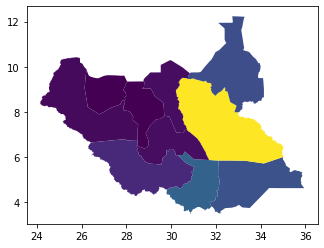

In [101]:
pop_affected_by_flood.plot(column='population_sum')

### Export output

In [102]:
pop_affected_by_flood.to_csv("pop_flooded_rp100.csv")
pop_affected_by_flood.to_file("adm1_pop_affected_by_flood.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


In [104]:
# Download files using the menu on left-hand side

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>